<a href="https://colab.research.google.com/github/willburr/humorous-headlines/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# Project  Set-up

The code blocks below provide the imports and set-up steps to run later sections. We import necessary libraries, set pytorch to use the GPU and set necessary seeds to add determinism.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
import torch.optim as optim
import codecs
import tqdm

# Helper code to perform stopword removal
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Imports for use of BERT
!pip install transformers
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Setting random seed and device
SEED = 1

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Downloading the data

Here we download the data files, load them into pandas and examine the first few columns of the test dataset

In [3]:
!wget -O train.csv https://drive.google.com/u/0/uc?id=1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=19WKir5IRn83NMcVgvNDrmgcDj1UIv7kt&export=download
!wget -O test.csv https://drive.google.com/u/0/uc?id=11pyqg27tGRC1iDo26C2b01bMETqdUwuf&export=download

--2021-02-28 13:21:06--  https://drive.google.com/u/0/uc?id=1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.138, 74.125.195.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m9e1ftsbk1keqtufko9rhmhontmcdf8f/1614518400000/13802342090854404605/*/1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX [following]
--2021-02-28 13:21:08--  https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m9e1ftsbk1keqtufko9rhmhontmcdf8f/1614518400000/13802342090854404605/*/1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX
Resolving doc-08-cc-docs.googleusercontent.com (doc-08-cc-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-08-cc-docs.googleusercontent.com (doc-08-cc-docs.googleusercontent.com)|74.

In [4]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
# Take a look at the data
test_df.head()

,id,original1,edit1,original2,edit2
0,704-2704,""" Pence Is Trying to Control Republican Politi...",barbers,""" Pence Is Trying to <Control/> Republican Pol...",Bungle
1,704-14395,""" Pence Is Trying to Control Republican Politi...",barbers,""" <Pence/> Is Trying to Control Republican Pol...",Witch
2,2704-14395,""" Pence Is Trying to <Control/> Republican Pol...",Bungle,""" <Pence/> Is Trying to Control Republican Pol...",Witch
3,11098-10186,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",woman
4,11098-2118,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",man


## Download and unzip GLOVE Embeddings

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-28 13:21:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-28 13:21:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-28 13:21:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

## Training Evaluation Utility Functions

In [7]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer, scheduler=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in range(1, number_epoch+1):
        
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            feature, target = batch
            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)

            correct, __ = model_performance(np.argmax(predictions.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            if scheduler:
              scheduler.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct

        valid_loss, valid_acc, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)

    return train_losses, train_accs, val_losses, val_accs

In [8]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)
            
            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            correct, __ = model_performance(np.argmax(pred, axis=1), trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_correct/no_observations, np.array(pred_all), np.array(trg_all)

In [9]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    correct_answers = (output == target)
    correct = sum(correct_answers)
    acc = np.true_divide(correct,len(output))

    if print_output:
        print(f'| Acc: {acc:.2f} ')

    return correct, acc

In [10]:
def eval_test(data_iter, model, ids, filename):
    """
    Evaluating model performance on the dev set
    """
    model.eval()

    pred_all = []


    with torch.no_grad():
        for batch in data_iter:
            
            batch = batch.to(device)
            # for RNN:
            model.batch_size = batch.shape[1]

            predictions = model(batch).squeeze(1)

            pred = predictions.detach().cpu().numpy()

            pred_all.extend(pred)

    pred_all = np.argmax(np.array(pred_all), axis=1)

    combined = list(zip(ids, pred_all))

    res = pd.DataFrame(combined, columns=['id', 'pred'])
    res.set_index('id', inplace=True, drop=True)

    res.to_csv(filename + '.csv')

    return res

# Data augmentation and Vocab Preparation

The following section provides the functions used to augment the data such that we flip the ordering of input sentences and flip the resulting label. We also define the classes and functions used for creating the vocabulary data structure that maintains mappings between words and indexes.

## Data augmentation

The substitute function performs the injection of the edit word into the original sentence. This is then used in get_edited_df to return the dataframe with columns containing the edited sentences.

In [11]:
import re

def substitute(sentence, edit):
  open_pos = sentence.find('<')
  close_pos = sentence.find('>')
  sub = sentence.replace(sentence[open_pos: close_pos + 1], edit)
  return sub

def get_edited_df(df, test=False):
  id = df['id']
  edited1 = df.apply(lambda x:substitute(x['original1'], x['edit1']), axis=1)
  edited2 = df.apply(lambda x:substitute(x['original2'], x['edit2']), axis=1)
  combined = list(zip(edited1,edited2))
  if test:
    id = df['id']
    combined = list(zip(id,edited1,edited2))
    return pd.DataFrame(combined, columns=['id','edited1', 'edited2'])
  return pd.DataFrame(combined, columns=['edited1', 'edited2'])

edited_train_df = get_edited_df(train_df)
edited_test_df = get_edited_df(test_df, True)

edited_train_df.head()

# We set our training data and test data
training_data = edited_train_df.values.tolist()
labels = list(train_df['label'])
test_data = np.array(edited_test_df.values.tolist())[:,1:].tolist()

## Define Vocab Class

This class stores mappings from word to index and index to words. It also provides utility functions to build the mappings from files or a list data structure.

In [12]:
class Vocabulary(object):
  """Data structure representing the vocabulary of a corpus."""
  def __init__(self):
    # Mapping from tokens to integers
    self._word2idx = {}

    # Reverse-mapping from integers to tokens
    self.idx2word = []

  def word2idx(self, word, default=None):
    """Returns the integer ID of the word or default if not found."""
    return self._word2idx.get(word, default)

  def add_word(self, word):
    """Adds the `word` into the vocabulary."""
    if word not in self._word2idx:
      self.idx2word.append(word)
      self._word2idx[word] = len(self.idx2word) - 1

  def build_from_list(self, words):
    for word in words:
      self.add_word(word)

  def build_from_file(self, fname):
    """Builds a vocabulary from a given corpus file."""
    with open(fname) as f:
      for line in f:
        words = line.strip().split()
        for word in words:
          self.add_word(word)

  def convert_idxs_to_words(self, idxs):
    """Converts a list of indices to words."""
    return ' '.join(self.idx2word[idx] for idx in idxs)

  def convert_words_to_idxs(self, words):
    """Converts a list of words to a list of indices."""
    return [self.word2idx(w) for w in words]

  def __len__(self):
    """Returns the size of the vocabulary."""
    return len(self.idx2word)
  
  def __repr__(self):
    return "Vocabulary with {} items".format(self.__len__())

## Vocab Preparation

create_vocab allows for the tokenization of the corpus and creation of a list of words to be passed to the vocabulary. It provides two flags which the user can set to execute data cleaning operations of punctuation and stopword removal.

In [13]:
def create_vocab(data, remove_punc=True, remove_stopwords=True):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    stop_words = set(stopwords.words('english'))
    
    for sentence_pair in data:
        tokenized_sentence_pair = []
        for sentence in sentence_pair:
            tokenized_sentence = []

            # Split on spaces
            tokens = sentence.split(' ')
            
            # Remove punctuation
            if remove_punc:
              tokens = [word for word in tokens if word.isalnum()]

            # Remove stopwords
            if remove_stopwords:
              tokens = [word for word in tokens if not word in stop_words]

            for token in tokens: 

                tokenized_sentence.append(token.lower())

            tokenized_sentence_pair.append(tokenized_sentence)
        tokenized_corpus.append(tokenized_sentence_pair)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence_pair in tokenized_corpus:

        for sentence in sentence_pair:

            for token in sentence:

                if token.lower() not in vocabulary:

                    vocabulary.append(token.lower())

    return vocabulary, tokenized_corpus

## Load the Dataset

In this section, we present the code that is used to create train and validation pytorch dataloaders with the data augmentation of flipping the input sentences applied to the train dataloader.

### Utility functions

We create a class to hold the dataset to be loaded into the dataloader.

In [14]:
# We create a Dataset so we can create minibatches
class Task2Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [15]:
# Used for collating our observations into minibatches:
def collate_fn_padd(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = batch
    else:
        batch_labels = [l for f, l in batch]
        batch_features = [f for f, l in batch]
    
    batch_features_len = [[len(s) for s in b] for b in batch_features]

    seq_tensor = torch.zeros((2, len(batch_features), np.max(batch_features_len))).long()

    # Shape of seq_tensor is batch_size x max_feature_len
    # It should be batch_size x 2 x max_feature_len

    for idx, (seq, seqlens) in enumerate(zip(batch_features, batch_features_len)):
        for i in range(2):
            seq_tensor[i, idx, :seqlens[i]] = torch.LongTensor(seq[i])

    if test:
      return seq_tensor

    batch_labels = torch.LongTensor(batch_labels)
    return seq_tensor, batch_labels

### Creating Dataloaders

The first function, flip_label, is used in the data augmentation process. Then the two following functions are used to create and return pytorch dataloaders for the training and test datasets. note that create_dataloaders splits the dataset into a training and validation set dataloader.

In [16]:
def flip_label(label):
  if label == 1:
    return 2
  elif label == 2:
    return 1
  else: 
    return label

def create_dataloaders(feature, labels, collate_fn, train_proportion=0.8, batch_size=32, flip=True, seed=1):
    torch.manual_seed(seed)

    # 'feature' is a list of lists, each containing embedding IDs for word tokens
    train_and_dev = Task2Dataset(feature, labels)

    train_examples = round(len(train_and_dev)*train_proportion)
    dev_examples = len(train_and_dev) - train_examples

    train_dataset, dev_dataset = random_split(train_and_dev,
                                              (train_examples,
                                                dev_examples))

    if flip:
        # Add the reverse examples to the training set to create more training data
        flipped_train_dataset = []
        for r in train_dataset:
          flipped_train_dataset.append((list(reversed(r[0])), flip_label(r[1])))
        train_dataset += flipped_train_dataset
      
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    return train_loader, dev_loader

def create_test_dataloader(feature, collate_fn, batch_size=32):

    test_loader = torch.utils.data.DataLoader(feature, batch_size=batch_size, collate_fn=collate_fn)
    
    return test_loader


# Approach 1: Using pre-trained representations

In this section, we explore three different methods for learning which of the two edited sentences are funnier. We first explore the use of the GloVe embeddings with a BiLSTM, then we use BERT embeddings with the same model structure and finally, we use the entire BERT architecture, including the transformer model.

## 1.1 Using pre-trained (GloVe) embeddings with a BiLSTM model

###Create vocab, load embeddings and create dataloader

In [17]:
# Tokenize training corpus
training_vocab, training_tokenized_corpus = create_vocab(training_data)

# Creating joint vocab from test and train
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data)

print("Vocab created.")

Vocab created.


In [18]:
# We create representations for our tokens
wvecs = [] # word vectors

vocab = Vocabulary()
# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.300d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          vocab.add_word(word)


wvecs = np.array(wvecs)

features = [[[vocab.word2idx(tok) for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in training_tokenized_corpus]

train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd)

print("Dataloaders created.")

Dataloaders created.


### BiLSTM Model definition

Note here that we have an optional parameter, use_attn. This parameter is not used for this approach, as we compare the performance of this model with learned embeddings and attention for approach 2.

In [19]:
class BiLSTM_classification(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers=1, dropout_p=0.2, use_attn=False):
        super(BiLSTM_classification, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(dropout_p)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout_p)

        self.use_attn = use_attn
        if use_attn:
            self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=1)
            self.attn_dropout = nn.Dropout(dropout_p)

        # The linear layer that maps from hidden state space to tag space
        self.final_layers = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, 3)
        )

    def forward(self, sentence):
      ## Take embeddings over each sentence
      embedding1 = self.emb_dropout(self.embedding(sentence[0]))
      embedding2 = self.emb_dropout(self.embedding(sentence[1]))

      # Permute embeddings so they are shape (seq_len, batch_size, emb_dim)
      embedding1 = embedding1.permute(1, 0, 2)
      embedding2 = embedding2.permute(1, 0, 2)

      # Pass embeddings through lstm
      # outputs are of shape (seq_len, batch_size, hidden_dim * 2)
      lstm_out_1, _ = self.lstm(embedding1.view(len(embedding1), -1, self.embedding_dim))
      lstm_out_2, _ = self.lstm(embedding2.view(len(embedding2), -1, self.embedding_dim))

      # pass through attention layers (used in approach 2)
      if self.use_attn:
          out_1 = self.attn_dropout(self.attn(lstm_out_1[-1].unsqueeze(0), lstm_out_1, lstm_out_1)[0].squeeze())
          out_2 = self.attn_dropout(self.attn(lstm_out_2[-1].unsqueeze(0), lstm_out_2, lstm_out_2)[0].squeeze())
      else:
          out_1, out_2 = lstm_out_1[-1], lstm_out_2[-1]
      
      # out_1 and out_2 are of shape (batch_size, hidden_dim * 2)
      # We concat so the shape becomes (batch_size, hidden_dim * 2 * 2)
      out = self.final_layers(torch.cat([out_1, out_2], 1))
      return out

### Define Hyperparameters

In [20]:
epochs = 20
INPUT_DIM = len(vocab) + 1
HIDDEN_DIM = 200 
EMBEDDING_DIM = 300
num_layers = 2
dropout = 0.3

### Model Instantiation and Training

In [21]:
model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, num_layers, dropout)
print("Model initialised.")

model.to(device)

# We provide the model with our embeddings
model.embedding.weight.data[1:].copy_(torch.from_numpy(wvecs))
# Freeze model embeddings
model.embedding.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

t_loss, t_acc, v_loss, v_acc = train(train_loader, dev_loader, model, epochs, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.96 | Train Accuracy: 0.45 |         Val. Loss: 0.96 | Val. Accuracy: 0.46 |
| Epoch: 02 | Train Loss: 0.95 | Train Accuracy: 0.47 |         Val. Loss: 0.94 | Val. Accuracy: 0.51 |
| Epoch: 03 | Train Loss: 0.92 | Train Accuracy: 0.53 |         Val. Loss: 0.96 | Val. Accuracy: 0.50 |
| Epoch: 04 | Train Loss: 0.86 | Train Accuracy: 0.59 |         Val. Loss: 0.95 | Val. Accuracy: 0.54 |
| Epoch: 05 | Train Loss: 0.75 | Train Accuracy: 0.66 |         Val. Loss: 0.97 | Val. Accuracy: 0.55 |
| Epoch: 06 | Train Loss: 0.63 | Train Accuracy: 0.73 |         Val. Loss: 1.02 | Val. Accuracy: 0.57 |
| Epoch: 07 | Train Loss: 0.52 | Train Accuracy: 0.78 |         Val. Loss: 1.04 | Val. Accuracy: 0.59 |
| Epoch: 08 | Train Loss: 0.44 | Train Accuracy: 0.82 |         Val. Loss: 1.16 | Val. Accuracy: 0.59 |
| Epoch: 09 | Train Loss: 0.38 | Train Accuracy: 0.84 |         Val. Loss: 1.25 | Val. Accuracy: 0.57 |
| Epoch: 10 | Train Loss: 0.3

### Obtain test set predictions

In [22]:
test_vocab, test_tokenized_corpus = create_vocab(test_data)
vectorized_test = [[[vocab.word2idx(tok) for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in test_tokenized_corpus]

test_features = vectorized_test
test_loader = create_test_dataloader(test_features, lambda b: collate_fn_padd(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "bilstm glove")

## (Aside) Evaluate data manipulation techniques

The next two cells contain code for evaluating the effects of performing the following data cleaning and augmentation operations:

*   Punctuation removal (Cleaning)
*   Stopword removal (Cleaning)
*   Sentence flipping (Augmentation)

These were tested on the BiLSTM model defined above in section 1.1, with the GloVE embeddings.


### Train models to gather experiment data

NOTE: The following cell will take a long time to run as it trains the model many times.


In [23]:
def get_accuracies(train_loader, dev_loader):

  epochs = 20
  INPUT_DIM = len(vocab) + 1
  HIDDEN_DIM = 200 
  EMBEDDING_DIM = 300
  num_layers = 2
  dropout = 0.3
  train_accs = []
  val_accs = []
  max_train_accs = []
  max_val_accs = []

  for i in range(10):

    model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, num_layers, dropout)
    print("Model initialised.")

    model.to(device)

    # We provide the model with our embeddings
    model.embedding.weight.data[1:].copy_(torch.from_numpy(wvecs))
    # Freeze model embeddings
    model.embedding.weight.requires_grad = False

    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)

    optimizer = torch.optim.Adam(model.parameters())

    _, train_acc, _, val_acc = train(train_loader, dev_loader, model, epochs, optimizer)
    train_accs.append(train_acc[-1])
    val_accs.append(val_acc[-1])
    max_train_accs.append(max(train_acc))
    max_val_accs.append(max(val_acc))

  return train_accs, val_accs, max_train_accs, max_val_accs

# Baseline
print("Running Baseline Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=0, remove_stopwords=0)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=0, remove_stopwords=0)
train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd, flip=0)
baseline_train_accs, baseline_val_accs, max_baseline_train_accs, max_baseline_val_accs = get_accuracies(train_loader, dev_loader)

# Punctuation Removal
print("Running Punctuation Removal Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=0)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=0)
train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd, flip=0)
punc_train_accs, punc_val_accs, max_punc_train_accs, max_punc_val_accs = get_accuracies(train_loader, dev_loader)

# Stop Word Removal
print("Running Stop Word Removal Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=0, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=0, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd, flip=0)
stop_train_accs, stop_val_accs, max_stop_train_accs, max_stop_val_accs = get_accuracies(train_loader, dev_loader)

# Both Data Cleaning
print("Running Both Data Cleaning Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd, flip=0)
clean_train_accs, clean_val_accs, max_clean_train_accs, max_clean_val_accs = get_accuracies(train_loader, dev_loader)

# Data Flipping
print("Running Data Flipping Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd, flip=1)
flip_train_accs, flip_val_accs, max_flip_train_accs, max_flip_val_accs = get_accuracies(train_loader, dev_loader)


### Plot box plots for each experiment

In [24]:
## Plot box plots!
data = {"No Data Cleaning": baseline_train_accs, "Punctuation Removal": punc_train_accs, "Stop Word Removal": stop_train_accs, "Both Data Cleaning": clean_train_accs}
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_title('Traning Accuracy For Data Cleaning')
ax1.boxplot(data.values(), showfliers=False)
ax1.set_xticklabels(data.keys())
plt.tight_layout()
plt.savefig('Data Cleaning Training.pdf', format='pdf')
plt.show()

data = {"No Data Cleaning": baseline_val_accs, "Punctuation Removal": punc_val_accs, "Stop Word Removal": stop_val_accs, "Both Data Cleaning": clean_val_accs}
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_title('Validation Accuracy For Data Cleaning')
ax1.boxplot(data.values(), showfliers=False)
ax1.set_xticklabels(data.keys())
plt.savefig('Data Cleaning Validation.pdf', format='pdf')
plt.show()

data = {"No Data Augmentation": clean_train_accs, "Data Augmentation": flip_train_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Training Accuracy For Data Augmentation')
ax1.boxplot(data.values(), showfliers=False)
ax1.set_xticklabels(data.keys())
plt.savefig('Data Augmentation Training.pdf', format='pdf')
plt.show()

data = {"No Data Augmentation": clean_val_accs, "Data Augmentation": flip_val_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Validation Accuracy For Data Augmentation')
ax1.boxplot(data.values(), showfliers=False)
ax1.set_xticklabels(data.keys())
plt.savefig('Data Augmentation Validation.pdf', format='pdf')
plt.show()

## 1.2 Using DistilBERT embeddings

In this section, we will tokenize the sentences using DistilBERT's tokenizer and load the embeddings into a BiLSTM model of the same structure used in the previous section.
 

### Tokenize sentences and load into dataloaders 

In [25]:
# Note that the following ones add an attention mask (used to tell BERT to ignore padding)
def collate_fn_padd_BERT_embeddings(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = batch
    else: 
        batch_labels = [l for f, l in batch]
        batch_features = [f for f, l in batch]

    batch_features_len = [[len(s) for s in b] for b in batch_features]

    seq_tensor = torch.zeros((2, len(batch), np.max(batch_features_len))).long()
    mask_tensor = torch.zeros((2, len(batch), np.max(batch_features_len))).long()

    # Shape of seq_tensor is batch_size x max_feature_len
    # It should be batch_size x 2 x max_feature_len

    for idx, (seq, seqlens) in enumerate(zip(batch_features, batch_features_len)):
        for i in range(2):
            seq_tensor[i, idx, :seqlens[i]] = torch.LongTensor(seq[i])
            mask_tensor[i, idx, :seqlens[i]] = torch.ones(seqlens[i])

    feature_tensor = torch.stack([seq_tensor, mask_tensor], dim=1)

    if test:
        return feature_tensor

    batch_labels = torch.LongTensor(batch_labels)
    return feature_tensor, batch_labels

In [26]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

input_id_pairs = []

for (sentence1, sentence2) in training_data:
    encoded_sentence1 = tokenizer.encode(sentence1)
    encoded_sentence2 = tokenizer.encode(sentence2)
    
    # Add the encoded sentence to the list.
    input_id_pairs.append([encoded_sentence1, encoded_sentence2])

train_loader, dev_loader = create_dataloaders(input_id_pairs, labels, collate_fn_padd_BERT_embeddings)

### BiLSTM model with DistilBERT embeddings

In [27]:
class BiLSTM_BERT_classification(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(BiLSTM_BERT_classification, self).__init__()
        self.hidden_dim = hidden_dim
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased',
            output_hidden_states = True, 
        )
        # The word embedding dimension given by concatenating last 4 hidden 
        # layers of BERT
        self.embedding_dim = 3072


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.final_layer = nn.Linear(hidden_dim * 4, 3)

    def compute_embeddings(self, feature):
        b_input_ids = feature[0].to(device)
        b_input_mask = feature[1].to(device)

        with torch.no_grad():
            # We aren't trying to train BERT here, only use its embeddings
            self.bert.eval()
            outputs = self.bert(
                b_input_ids,
                attention_mask=b_input_mask
            )
            hidden_states = outputs.hidden_states
        
        return torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)

    def forward(self, sentences):
      # Take BERT embeddings over each sentence
        embedding1 = self.compute_embeddings(sentences[0])
        embedding2 = self.compute_embeddings(sentences[1])

        # Permute embeddings so they are shape (seq_len, batch_size, emb_dim)
        embedding1 = embedding1.permute(1, 0, 2)
        embedding2 = embedding2.permute(1, 0, 2)

        # Pass embeddings through lstm
        # outputs are of shape (seq_len, batch_size, hidden_dim * 2)
        lstm_out_1, _ = self.lstm(embedding1.view(len(embedding1), -1, self.embedding_dim))
        lstm_out_2, _ = self.lstm(embedding2.view(len(embedding2), -1, self.embedding_dim))
 
        # lstm_out_1[-1] and lstm_out_2[-1] are of shape (batch_size, hidden_dim * 2)
        # We concat so the shape becomes (batch_size, hidden_dim * 2 * 2)
        out = self.final_layer(torch.cat((lstm_out_1[-1], lstm_out_2[-1]), 1))
        return out

### Define Hyperparameters

In [28]:
bert_epochs = 8
HIDDEN_DIM = 400 
num_layers = 4

### Model Instantiation and Training

In [29]:
model_bert = BiLSTM_BERT_classification(HIDDEN_DIM, num_layers)
print("Model initialised.")

model_bert = model_bert.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model_bert.parameters())

bert_t_loss, bert_t_acc, bert_v_loss, bert_v_acc = train(train_loader, dev_loader, model_bert, bert_epochs, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.97 | Train Accuracy: 0.44 |         Val. Loss: 0.96 | Val. Accuracy: 0.45 |
| Epoch: 02 | Train Loss: 0.95 | Train Accuracy: 0.49 |         Val. Loss: 0.94 | Val. Accuracy: 0.53 |
| Epoch: 03 | Train Loss: 0.90 | Train Accuracy: 0.58 |         Val. Loss: 0.91 | Val. Accuracy: 0.56 |
| Epoch: 04 | Train Loss: 0.80 | Train Accuracy: 0.66 |         Val. Loss: 0.93 | Val. Accuracy: 0.61 |
| Epoch: 05 | Train Loss: 0.66 | Train Accuracy: 0.74 |         Val. Loss: 1.01 | Val. Accuracy: 0.61 |
| Epoch: 06 | Train Loss: 0.52 | Train Accuracy: 0.81 |         Val. Loss: 1.27 | Val. Accuracy: 0.62 |
| Epoch: 07 | Train Loss: 0.41 | Train Accuracy: 0.85 |         Val. Loss: 1.37 | Val. Accuracy: 0.63 |
| Epoch: 08 | Train Loss: 0.34 | Train Accuracy: 0.87 |         Val. Loss: 1.58 | Val. Accuracy: 0.62 |


### Obtain test set predictions

In [30]:
test_id_pairs = []

for (sentence1, sentence2) in test_data:
    encoded_sentence1 = tokenizer.encode(sentence1)
    encoded_sentence2 = tokenizer.encode(sentence2)
    
    # Add the encoded sentence to the list.
    test_id_pairs.append([encoded_sentence1, encoded_sentence2])

test_loader = create_test_dataloader(test_id_pairs, lambda b: collate_fn_padd_BERT_embeddings(b, test=True))

bert_preds = eval_test(test_loader, model_bert, edited_test_df['id'], "bilstm bert")

## 1.3 Fine-tuning DistilBERT

The following code uses the pre-trained DistilBERT model as well as it's own embeddings in an attempt to solve the task. We fine tune the model, and evaluate it's performance on the test set as we have done with the others.

### Tokenize sentences and load into dataloaders

In [31]:
def collate_fn_padd_BERT(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = [cls + s1 + sep + s2 for (s1, s2) in batch]
    else: 
        batch_features = [cls + s1 + sep + s2 for (s1, s2), l in batch]
        batch_labels = [l for f, l in batch]

    batch_features_len = [len(f) for f in batch_features]

    seq_tensor = torch.zeros((len(batch_features), max(batch_features_len))).long()
    mask_tensor = torch.zeros((len(batch_features), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
        mask_tensor[idx, :seqlen] = torch.ones(seqlen)

    # Put sequence and tensor together
    feature_tensor = torch.stack([seq_tensor, mask_tensor])

    if test:
        return feature_tensor
  
    batch_labels = torch.LongTensor(batch_labels)
    return feature_tensor, batch_labels

In [32]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

input_id_pairs = []

cls = tokenizer.encode('[CLS]')
sep = tokenizer.encode('[SEP]')

for (sentence1, sentence2) in training_data:
    encoded_sentence1 = tokenizer.encode(sentence1, add_special_tokens=False)
    encoded_sentence2 = tokenizer.encode(sentence2, add_special_tokens=False)
    
    # Add the encoded sentence to the list.
    input_id_pairs.append([encoded_sentence1, encoded_sentence2])

train_loader, dev_loader = create_dataloaders(input_id_pairs, labels, collate_fn_padd_BERT, flip=False)

### DistilBert for Humour detection

In [33]:
class HumourBert(nn.Module):
    def __init__(self):
        super(HumourBert, self).__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', 
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False
        )
    
    def forward(self, feature):
        b_input_ids = feature[0].to(device)
        b_input_mask = feature[1].to(device)
        outputs = self.bert(
            b_input_ids,
            attention_mask=b_input_mask
        )
        return outputs.logits

### Model Instantiation and Training

In [34]:
model = HumourBert().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 16

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

t_loss, t_acc, v_loss, v_acc = train(train_loader, dev_loader, model, epochs, optimizer, scheduler)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training model.
| Epoch: 01 | Train Loss: 0.97 | Train Accuracy: 0.44 |         Val. Loss: 0.96 | Val. Accuracy: 0.46 |
| Epoch: 02 | Train Loss: 0.95 | Train Accuracy: 0.48 |         Val. Loss: 0.96 | Val. Accuracy: 0.48 |
| Epoch: 03 | Train Loss: 0.94 | Train Accuracy: 0.51 |         Val. Loss: 0.96 | Val. Accuracy: 0.48 |
| Epoch: 04 | Train Loss: 0.89 | Train Accuracy: 0.57 |         Val. Loss: 0.99 | Val. Accuracy: 0.49 |
| Epoch: 05 | Train Loss: 0.80 | Train Accuracy: 0.63 |         Val. Loss: 1.04 | Val. Accuracy: 0.49 |
| Epoch: 06 | Train Loss: 0.71 | Train Accuracy: 0.69 |         Val. Loss: 1.12 | Val. Accuracy: 0.50 |
| Epoch: 07 | Train Loss: 0.62 | Train Accuracy: 0.73 |         Val. Loss: 1.22 | Val. Accuracy: 0.50 |
| Epoch: 08 | Train Loss: 0.55 | Train Accuracy: 0.77 |         Val. Loss: 1.35 | Val. Accuracy: 0.50 |
| Epoch: 09 | Train Loss: 0.48 | Train Accuracy: 0.80 |         Val. Loss: 1.43 | Val. Accuracy: 0.49 |
| Epoch: 10 | Train Loss: 0.44 | Train Accuracy:

### Obtain test set predictions

In [35]:
test_id_pairs = []

for (sentence1, sentence2) in test_data:
    encoded_sentence1 = tokenizer.encode(sentence1, add_special_tokens=False)
    encoded_sentence2 = tokenizer.encode(sentence2, add_special_tokens=False)
    
    # Add the encoded sentence to the list.
    test_id_pairs.append([encoded_sentence1, encoded_sentence2])

test_loader = create_test_dataloader(test_id_pairs, lambda b: collate_fn_padd_BERT(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "bert model")

# Approach 2: No pre-trained representations

In this section we will explore approaches that don't use pre-trained embeddings such as GloVe or BERT used in the previous section.

Instead, we look to compare two flavours of neural models, with learned embeddings. The first of which, being the same Bidirectional LSTM model defined in the previous approach and the second being a modified version of this BiLSTM to use attention.

We use two of the pre-provided cells as baselines to compare performance with our neural models, the most common class predictions and the TF-IDF model.

## 2.1 Baselines

### Prepare data

In [36]:
# Use the concatenation of the edited sentences as training data for baseline
train_and_dev = [f"{s1} {s2}" for s1, s2 in training_data]
train_proportion = 0.8

train_data, dev_data, training_y, dev_y = train_test_split(train_and_dev, labels,
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

### Most frequent class

In [37]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + 1  # 1 is most common class
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, torch.tensor(dev_y), True)


Baseline performance:
| Acc: 0.45 


### TF-IDF model

In [38]:
# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(train_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
naive_model = MultinomialNB().fit(train_counts, training_y)

# Train predictions
predicted_train = naive_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = naive_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")

sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| Acc: 0.71 

Dev performance:
| Acc: 0.50 


## 2.2 Neural Models

### Create vocab and load data into dataloaders

Again, we must tokenize our corpus, using functions defined in the first section at the top of this notebook.

We then use the Vocabulary class to create word-index mappings and from these get our vectorised sequences which we can load into a pytorch dataloader.

In [39]:
# We set our training data and test data
training_data = edited_train_df.values.tolist()
test_data = np.array(edited_test_df.values.tolist())[:,1:].tolist()
labels = list(train_df['label'])

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)

# Creating joint vocab from test and train
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data)

vocab = Vocabulary()

# 0-padding token
vocab.add_word('<pad>')
# sentence start
vocab.add_word('<s>')
# sentence end
vocab.add_word('</s>')
# Unknown words
vocab.add_word('<unk>')
vocab.build_from_list(joint_vocab)

features = [[[vocab._word2idx[tok] for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in training_tokenized_corpus]

train_loader, dev_loader = create_dataloaders(features, labels, collate_fn_padd)

print("Dataloaders created.")

Dataloaders created.


### Define Hyperparameters

In [40]:
attn_epochs = 20
INPUT_DIM = len(vocab) + 1
HIDDEN_DIM = 200 
EMBEDDING_DIM = 300
num_layers = 2
dropout = 0.3

### 2.2.1 Train Bi-LSTM with learnable embeddings (No attention)

Here we train the model defined in section 1.1, but it must learn it's own embeddings on the data. We train it with the use_attn flag set to false (default)



In [41]:
model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, num_layers, dropout)
print("Model initialised.")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

t_loss, t_acc, v_loss, v_acc = train(train_loader, dev_loader, model, attn_epochs, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.96 | Train Accuracy: 0.45 |         Val. Loss: 0.98 | Val. Accuracy: 0.45 |
| Epoch: 02 | Train Loss: 0.90 | Train Accuracy: 0.50 |         Val. Loss: 1.01 | Val. Accuracy: 0.49 |
| Epoch: 03 | Train Loss: 0.78 | Train Accuracy: 0.61 |         Val. Loss: 1.17 | Val. Accuracy: 0.49 |
| Epoch: 04 | Train Loss: 0.64 | Train Accuracy: 0.70 |         Val. Loss: 1.33 | Val. Accuracy: 0.52 |
| Epoch: 05 | Train Loss: 0.52 | Train Accuracy: 0.77 |         Val. Loss: 1.38 | Val. Accuracy: 0.53 |
| Epoch: 06 | Train Loss: 0.44 | Train Accuracy: 0.81 |         Val. Loss: 1.34 | Val. Accuracy: 0.58 |
| Epoch: 07 | Train Loss: 0.38 | Train Accuracy: 0.83 |         Val. Loss: 1.44 | Val. Accuracy: 0.58 |
| Epoch: 08 | Train Loss: 0.32 | Train Accuracy: 0.87 |         Val. Loss: 1.55 | Val. Accuracy: 0.60 |
| Epoch: 09 | Train Loss: 0.29 | Train Accuracy: 0.88 |         Val. Loss: 1.53 | Val. Accuracy: 0.59 |
| Epoch: 10 | Train Loss: 0.2

### 2.2.2 Train BiLSTM with attention with learnable embeddings

In [42]:
model_attn = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, num_layers, dropout, use_attn=True)
print("Model initialised.")
model_attn.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model_attn.parameters())

attn_t_loss, attn_t_acc, attn_v_loss, attn_v_acc = train(train_loader, dev_loader, model_attn, attn_epochs, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.96 | Train Accuracy: 0.46 |         Val. Loss: 0.98 | Val. Accuracy: 0.44 |
| Epoch: 02 | Train Loss: 0.89 | Train Accuracy: 0.53 |         Val. Loss: 1.14 | Val. Accuracy: 0.52 |
| Epoch: 03 | Train Loss: 0.74 | Train Accuracy: 0.64 |         Val. Loss: 1.21 | Val. Accuracy: 0.57 |
| Epoch: 04 | Train Loss: 0.57 | Train Accuracy: 0.74 |         Val. Loss: 1.39 | Val. Accuracy: 0.54 |
| Epoch: 05 | Train Loss: 0.46 | Train Accuracy: 0.80 |         Val. Loss: 1.54 | Val. Accuracy: 0.57 |
| Epoch: 06 | Train Loss: 0.38 | Train Accuracy: 0.84 |         Val. Loss: 1.49 | Val. Accuracy: 0.57 |
| Epoch: 07 | Train Loss: 0.32 | Train Accuracy: 0.87 |         Val. Loss: 1.80 | Val. Accuracy: 0.60 |
| Epoch: 08 | Train Loss: 0.28 | Train Accuracy: 0.89 |         Val. Loss: 1.82 | Val. Accuracy: 0.60 |
| Epoch: 09 | Train Loss: 0.24 | Train Accuracy: 0.90 |         Val. Loss: 1.91 | Val. Accuracy: 0.62 |
| Epoch: 10 | Train Loss: 0.2

### Obtain test set predictions (for both models)

In [43]:
test_vocab, test_tokenized_corpus = create_vocab(test_data)
test_features = [[[vocab.word2idx(tok) for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in test_tokenized_corpus]

test_loader = create_test_dataloader(test_features, lambda b: collate_fn_padd(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "lstm learned embeddings")
attn_preds = eval_test(test_loader, model_attn, edited_test_df['id'], "lstm learned embeddings + attn")

# Evaluation

In this section we display code that allows for the comparison and evaluation of our best models from each approach, namely the BiLSTM with BERT embeddings in approach 1 and the BiLSTM with attention in approach 2.

We observe the losses and accuracies during training for both training and validation sets, and then look into more detail at the F1 score and confusion matrices on the test set.

Note that the code below assumes the relevant code cells have been run, using variables for model_bert and model_attn, that have already been trained on the dataset. We also assume that their losses and accuracies are stored in variables used below.

In [44]:
bert_epochs_arr = np.arange(bert_epochs)
attn_epochs_arr = np.arange(attn_epochs)

## Loss Curves

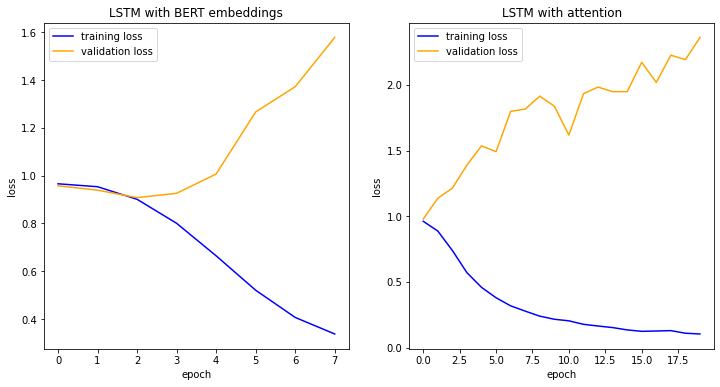

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("LSTM with BERT embeddings")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(bert_epochs_arr, bert_t_loss, color='blue', label='training loss')
ax1.plot(bert_epochs_arr, bert_v_loss, color='orange', label='validation loss')
ax1.legend()
ax2.set_title("LSTM with attention")
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.plot(attn_epochs_arr, attn_t_loss, color='blue', label='training loss')
ax2.plot(attn_epochs_arr, attn_v_loss, color='orange', label='validation loss')
ax2.legend()
plt.savefig('Loss Curves.pdf', format='pdf')
plt.show()

## Accuracies

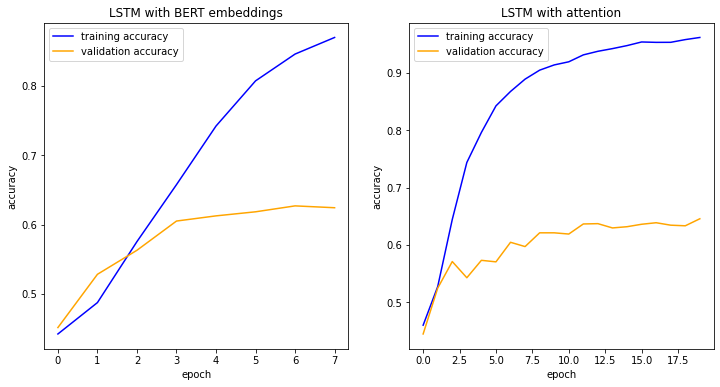

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("LSTM with BERT embeddings")
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.plot(bert_epochs_arr, bert_t_acc, color='blue', label='training accuracy')
ax1.plot(bert_epochs_arr, bert_v_acc, color='orange', label='validation accuracy')
ax1.legend()
ax2.set_title("LSTM with attention")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.plot(attn_epochs_arr, attn_t_acc, color='blue', label='training accuracy')
ax2.plot(attn_epochs_arr, attn_v_acc, color='orange', label='validation accuracy')
ax2.legend()
plt.savefig('Accuracy Curves.pdf', format='pdf')
plt.show()

## Test set metrics

### Download test labels

In [47]:
!wget -O test_labels.csv https://drive.google.com/u/0/uc?id=1Ofb18TUPhIkn_ArAyFhqo9_ZSBgmiBIo&export=download
test_labels_df = pd.read_csv('test_labels.csv')
test_labels_df.head()
test_labels = list(test_labels_df['label'])

--2021-02-28 14:31:14--  https://drive.google.com/u/0/uc?id=1Ofb18TUPhIkn_ArAyFhqo9_ZSBgmiBIo
Resolving drive.google.com (drive.google.com)... 173.194.203.102, 173.194.203.100, 173.194.203.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.203.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j8d1eulg821pu2c9pi0hiepkoiir1u5k/1614522600000/18042724966187936417/*/1Ofb18TUPhIkn_ArAyFhqo9_ZSBgmiBIo [following]
--2021-02-28 14:31:14--  https://doc-14-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j8d1eulg821pu2c9pi0hiepkoiir1u5k/1614522600000/18042724966187936417/*/1Ofb18TUPhIkn_ArAyFhqo9_ZSBgmiBIo
Resolving doc-14-70-docs.googleusercontent.com (doc-14-70-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-14-70-docs.googleusercontent.com (doc-14-70-docs.googleusercontent.com)

In [48]:
## Convert predictions into a list.
bert_preds = list(bert_preds['pred'])
attn_preds = list(attn_preds['pred'])

### Confusion matrices

In [49]:
bert_cmat = confusion_matrix(test_labels, bert_preds)
attn_cmat = confusion_matrix(test_labels, attn_preds)

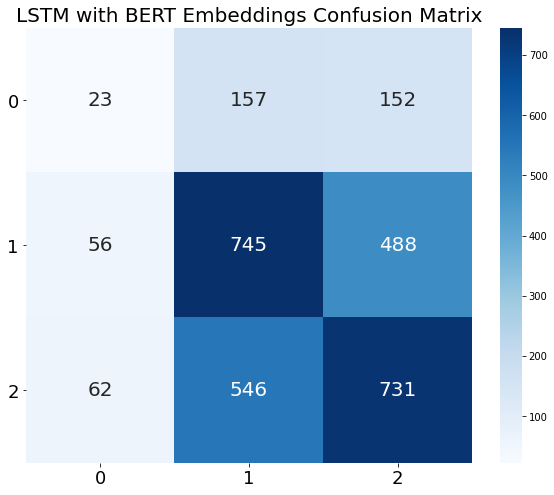

In [55]:
plt.figure(figsize = (10, 8))
plt.title('LSTM with BERT Embeddings Confusion Matrix', fontsize=20)
bert_cmat_plt = sn.heatmap(bert_cmat, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 20}, fmt='g')
bert_cmat_plt.set_xticklabels(bert_cmat_plt.get_xmajorticklabels(), fontsize = 18)
bert_cmat_plt.set_yticklabels(bert_cmat_plt.get_ymajorticklabels(), fontsize = 18, rotation=0)
plt.savefig('BERT Confusion Matrix.pdf', format='pdf')
plt.show()

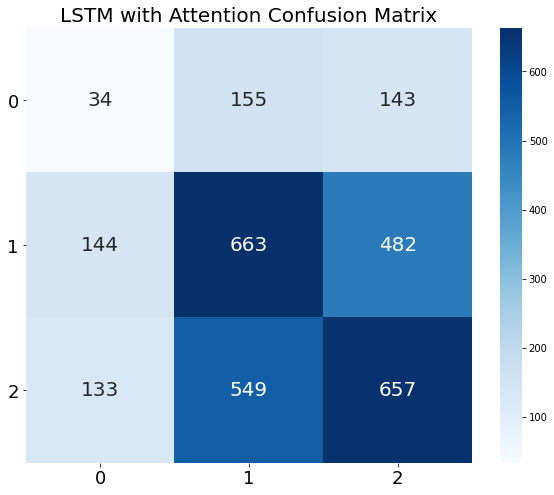

In [56]:
plt.figure(figsize = (10, 8))
plt.title('LSTM with Attention Confusion Matrix', fontsize=20)
attn_cmat_plt = sn.heatmap(attn_cmat, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 20}, fmt='g')
attn_cmat_plt.set_xticklabels(attn_cmat_plt.get_xmajorticklabels(), fontsize = 18)
attn_cmat_plt.set_yticklabels(attn_cmat_plt.get_ymajorticklabels(), fontsize = 18, rotation=0)
plt.savefig('Attn Confusion Matrix.pdf', format='pdf')
plt.show()

### F1 Score

In [52]:
bert_f1 = f1_score(test_labels, bert_preds, average='weighted')
attn_f1 = f1_score(test_labels, attn_preds, average='weighted')
print(f"F1 score for lstm with bert embeddings = {bert_f1}")
print(f"F1 score for lstm with attention = {attn_f1}")

F1 score for lstm with bert embeddings = 0.49201913998907587
F1 score for lstm with attention = 0.4560567045167903
